In [1]:
"""
Cascaded Convolution Model

- Pranav Shrestha (ps2958)
- Jeffrey Wan (jw3468)

"""

import pickle # 用来序列化的包
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer # 该类允许使用两种方法向量化一个文本语料库： 将每个文本转化为一个整数序列（每个整数都是词典中标记的索引）； 或者将其转化为一个向量，其中每个标记的系数可以是二进制值、词频、TF-IDF权重等。
from keras.utils import to_categorical
from keras.models import Model, Input
from keras.layers import Embedding, Dense, TimeDistributed, Concatenate, BatchNormalization
from keras.layers import Bidirectional, Activation, Dropout, GRU, Conv1D

from sklearn.model_selection import train_test_split, KFold
from keras.metrics import categorical_accuracy
from keras import backend as K
from keras.regularizers import l1, l2
import tensorflow as tf

import os

os.environ['CUDA_VISIBLE_DEVICES'] = '/gpu:0'



### 读数据,这两个数据都是做过onehot编码的
# cb6133         = np.load("../data/cb6133.npy")
cb6133filtered = np.load("../data/cullpdb+profile_6133_filtered.npy.gz")
cb513          = np.load("../data/cb513+profile_split1.npy.gz")

# 看一眼数据大小
# print(cb6133.shape)
print(cb6133filtered.shape) #(5534, 39900),39900=57*700
print(cb513.shape)
# cb6133filtered[0,-57:-1]

maxlen_seq = r = 700 # protein residues padded to 700，统一设置成700的序列长度
f = 57  # number of features for each residue，onehot后的总特征数量=22+8+5+22

residue_list = list('ACEDGFIHKMLNQPSRTWVYX') + ['NoSeq'] # 长度是21+1
q8_list      = list('LBEGIHST') + ['NoSeq']

columns = ["id", "len", "input", "profiles", "expected"]

def get_data(arr, bounds=None): # 把预测得到的分段的onehot编码解码成我们想要的氨基酸序列
    
    if bounds is None: bounds = range(len(arr)) # 应该是蛋白质序列的条数
    
    data = [None for i in bounds] # 新建了一个长度和arr一样的空列表
    for i in bounds:
        seq, q8, profiles = '', '', []
        for j in range(r):
            jf = j*f # 1*57---->700*57
            
            # Residue convert from one-hot to decoded，应该是从onehot编码解码为氨基酸序列
            residue_onehot = arr[i,jf+0:jf+22] # 取了某一条氨基酸序列中的某个氨基酸的57各特征中的前22个特征的概率？
            residue = residue_list[np.argmax(residue_onehot)] # 这22个特征中概率最大的成为这个氨基酸的特征，此处为氨基酸的种类

            # Q8 one-hot encoded to decoded structure symbol，应该是从onehot解码为氨基酸二级结构
            residue_q8_onehot = arr[i,jf+22:jf+31] # 同上
            residue_q8 = q8_list[np.argmax(residue_q8_onehot)] # 同上

            if residue == 'NoSeq': break      # terminating sequence symbol，遇到编码为NoSeq，应该是意味着这串氨基酸序列结束了

            # 下面这仨应该就是蛋白质的一些其他特征，包括profile（亲戚关系？）啥的，可能还有什么像是溶剂可溶性？
            nc_terminals = arr[i,jf+31:jf+33] # nc_terminals = [0. 0.]
            sa = arr[i,jf+33:jf+35]           # sa = [0. 0.]
            profile = arr[i,jf+35:jf+57]      # profile features，这个就是PSSM亲戚特征
            
            
            
            seq += residue # concat residues into amino acid sequence，把氨基酸序列预测结果连接起来
            q8  += residue_q8 # concat secondary structure into secondary structure sequence， 把氨基酸二级结构预测结果连接起来
            profiles.append(profile) # 将亲戚信息保存起来，后续用来作为网络的输入的一部分
        
        data[i] = [str(i+1), len(seq), seq, np.array(profiles), q8] # 【蛋白质编号，蛋白质长度，蛋白质序列，蛋白质亲戚信息，蛋白质二级结构】
    
    return pd.DataFrame(data, columns=columns) # 输出成pandas的数据结构，二维的貌似？

### Train-test Specification，得到了漂亮的数据结构
train_df = get_data(cb6133filtered) # 用来训练
test_df  = get_data(cb513) # 用来测试

# The custom accuracy metric used for this task，要自己定义一个正确率，不然keras默认的那个accuracy是包含那些700的长度后面补的NoSeq
def myaccuracy(y_true, y_pred):
    y = tf.argmax(y_true, axis =- 1) # 用最后一个维度进行封包，然后不同包之间进行比较，比较对应位置的大小
    y_ = tf.argmax(y_pred, axis =- 1)
    mask = tf.greater(y, 0) # y中比0大的赋值为true，比0小和等于0的赋值为false，这样子就把后面那些空的去掉了，只比对有值的内容的正确率
    return K.cast(K.equal(tf.boolean_mask(y, mask), tf.boolean_mask(y_, mask)), K.floatx()) # floatx是默认的浮点数类型，tf.boolean_mask返回mask为true的y的对应位置的内容，equal返回布尔型的list，cast类型转换此处为1.和0

# Maps the sequence to a one-hot encoding
# 简单onehot解码
def onehot_to_seq(oh_seq, index):
    s = ''
    for o in oh_seq:
        i = np.argmax(o)
        if i != 0:
            s += index[i] # 字符串加法
        else:
            break
    return s

# 简单onehot编码
def seq2onehot(seq, n):
    out = np.zeros((len(seq), maxlen_seq, n)) # （氨基酸序列条数，700，22（onehot的维度））
    for i in range(len(seq)): # i是第几条氨基酸序列的序号
        for j in range(maxlen_seq): # j是第i条氨基酸序列的第几个氨基酸的序号，1---700
            out[i, j, seq[i, j]] = 1 # 懂了，seq[i,j]这个值是多少（x），我们就在第几(x)个位置填1，这个值只能有22种可能性
    return out

# Computes and returns the n-grams of a particular sequence, defaults to trigrams
# ngrams第N个词的出现只与前面N-1个词相关，而与其它任何词都不相关，整句的概率就是各个词出现概率的乘积。这些概率可以通过直接从语料中统计N个词同时出现的次数得到。常用的是二元的Bi-Gram和三元的Tri-Gram
def seq2ngrams(seqs, n = 1): # 此处n=1，所以某一条氨基酸序列中每个氨基酸前后不相关，所以此时实际效果就像把序列每个氨基酸分开了
    return np.array([[seq[i : i + n] for i in range(len(seq))] for seq in seqs])

# Loading and converting the inputs to trigrams，加载并且将其转置，此处转置没啥用，但是如果上面n大于1，就有用了
train_input_seqs, train_target_seqs = \
    train_df[['input', 'expected']][(train_df.len.astype(int) <= maxlen_seq)].values.T # astpye(int)将int64转为int32，.values提取值（不包含序号），.T表示转置
train_input_grams = seq2ngrams(train_input_seqs)

# Same for test，同上
test_input_seqs = test_df['input'].values.T
test_input_grams = seq2ngrams(test_input_seqs)

# Initializing and defining the tokenizer encoders and decoders based on the train set
# Tokenizer是一个用于向量化文本，或将文本转换为序列（即单词在字典中的下标构成的列表，从1算起）的类。Tokenizer实际上只是生成了一个字典，并且统计了词频等信息，并没有把文本转成需要的向量表示。
tokenizer_encoder = Tokenizer()
tokenizer_encoder.fit_on_texts(train_input_grams) # 生成氨基酸种类词典
tokenizer_decoder = Tokenizer(char_level = True) # char_level：如果为True，每个字符将被视为一个标记
tokenizer_decoder.fit_on_texts(train_target_seqs) # 生成氨基酸二级结构词典

# Using the tokenizer to encode and decode the sequences for use in training，用字典来将字符转换为数字
# Inputs
train_input_data = tokenizer_encoder.texts_to_sequences(train_input_grams) # 将氨基酸序列通过字典,变成数字序列
train_input_data = sequence.pad_sequences(train_input_data,
                                          maxlen = maxlen_seq, padding='post') # 把不等长的list变成等长,默认填充是０,padding='post'是后填充即后面是0

# Targets
train_target_data = tokenizer_decoder.texts_to_sequences(train_target_seqs) # 将氨基酸二级结构序列通过字典，变成数字序列
train_target_data = sequence.pad_sequences(train_target_data,
                                           maxlen = maxlen_seq, padding='post') # 同上
train_target_data = to_categorical(train_target_data) # to_categorical就是将类别向量转换为二进制（只有0和1）的矩阵类型表示，此处用途为简易onehot

# Use the same tokenizer defined on train for tokenization of test，对测试集进行同上操作
test_input_data = tokenizer_encoder.texts_to_sequences(test_input_grams)
test_input_data = sequence.pad_sequences(test_input_data,
                                         maxlen = maxlen_seq, padding='post')
test_target_data = tokenizer_decoder.texts_to_sequences(test_df.expected.values) # 将测试集的氨基酸二级结构序列通过字典，变成数字序列
test_target_data = sequence.pad_sequences(test_target_data,
                                           maxlen = maxlen_seq, padding='post') # 同上
test_target_data=seq2onehot(test_target_data,n_tags) # 将测试集的氨基酸二级结构序列进行onehot

# Computing the number of words and number of tags for the keras model，统计一下两个字典的数量，keras运行时需要这个参数
n_words = len(tokenizer_encoder.word_index) + 1
n_tags = len(tokenizer_decoder.word_index) + 1

train_input_data_alt = train_input_data # 做了个备份
train_input_data = seq2onehot(train_input_data, n_words) # 对训练集的data进行onehot
train_profiles = train_df.profiles.values # 取出PSSM信息

test_input_data_alt = test_input_data # 同上
test_input_data = seq2onehot(test_input_data, n_words)
test_profiles = test_df.profiles.values

# 下面这一段的作用是把5534条不同长度的氨基酸序列中每个氨基酸的PSSM信息，存成一样700长的氨基酸序列中每个氨基酸的PSSM信息，存成三维的np数组，补充出来的那些氨基酸的PSSM信息都是0
train_profiles_np = np.zeros((len(train_profiles), maxlen_seq, 22))
for i, profile in enumerate(train_profiles):
    for j in range(profile.shape[0]):
        for k in range(profile.shape[1]):
            train_profiles_np[i, j, k] = profile[j, k]

# 同上
test_profiles_np = np.zeros((len(test_profiles), maxlen_seq, 22))
for i, profile in enumerate(test_profiles):
    for j in range(profile.shape[0]):
        for k in range(profile.shape[1]):
            test_profiles_np[i, j, k] = profile[j, k]

def decode_results(y_, reverse_decoder_index): # 根据字典进行onehot解码
    print("prediction: " + str(onehot_to_seq(y_, reverse_decoder_index).upper())) # .upper()小写字母转为大写字母
    return str(onehot_to_seq(y_, reverse_decoder_index).upper())

def run_test(_model, data1, data2, data3, csv_name, npy_name):
    reverse_decoder_index = {value:key for key,value in tokenizer_decoder.word_index.items()} # 把字典反向，用来解码，现在是1:'h'这样子
    reverse_encoder_index = {value:key for key,value in tokenizer_encoder.word_index.items()} # 把字典反向用来编码
    
    # Get predictions using our model
    y_test_pred = _model.predict([data1, data2, data3]) # 【我们自己onehot的氨基酸种类序列，embedding张成的64维的氨基酸种类序列，PSSM信息】

    decoded_y_pred = []
    for i in range(len(test_input_data)):
        res = decode_results(y_test_pred[i], reverse_decoder_index) # 应该是从onehot解码成二级结构序列
        decoded_y_pred.append(res)

    # Set Columns，设置输出的dataframe有哪些内容
    out_df = pd.DataFrame()
    out_df["id"] = test_df.id.values
    out_df["real"] = test_df.expected.values
    out_df["predict"] = decoded_y_pred

    # 输出一下测试集的预测正确率
    testaccseq=myaccuracy(test_target_data,y_test_pred)
    testacc=np.sum(testaccseq)/testaccseq.shape
    print('测试集的正确率：',testacc)
    # Save results，这里保存的是解码后的
    with open(csv_name, "w") as f:
        out_df.to_csv(f, index=False)

    np.save(npy_name, y_test_pred) # 这里保存的是没解码的


""" Run below for a single run """
def train(X_train, y_train, X_val=None, y_val=None):
    """
    Main Training function with the following properties:
        Optimizer - Nadam
        Loss function - Categorical Crossentropy
        Batch Size - 128 (any more will exceed Collab GPU RAM)
        Epochs - 50
    """
    model = CNN_BIGRU() # 实例化自己定义的网络
    model.compile(
        optimizer="Nadam", # 某种优化算法
        loss = "categorical_crossentropy", # 交叉熵损失函数
        metrics = ["accuracy", myaccuracy]) # 衡量指标：700个的正确率（其中包括后面补的0），我自己写的正确率（序列多长算多长）
    
    
    #########################
    print(model.summary())
    
    
    if X_val is not None and y_val is not None:
        history = model.fit( X_train, y_train,
            batch_size = 128, epochs = 100,
            validation_data = (X_val, y_val)) # 用来评估损失，以及在每轮结束时的任何模型度量指标。模型将不会在这个数据上进行训练。
    else:
        history = model.fit( X_train, y_train,
            batch_size = 128, epochs = 100, verbose=1) # 一个 History 对象。其 History.history 属性是连续 epoch 训练损失和评估值，以及验证集损失和评估值的记录（如果适用）。

    return history, model

""" Build model """
def conv_block(x, activation=True, batch_norm=True, drop_out=True, res=True): # 自己定义一个卷积层
    cnn = Conv1D(64, 11, padding="same")(x) # 将（5534,700,22+64+22）卷积到（5534,700,64），这里不用各自卷积是因为本来就是随机的卷积核
    if activation: cnn = TimeDistributed(Activation("relu"))(cnn) # 这个封装器将一个层应用于输入的每个时间片（一个batch中的每个样本）。输入至少为 3D，且第一个维度应该是时间所表示的维度。懂了，因为每条氨基酸序列之间并没有什么关系，所以各自操作
    if batch_norm: cnn = TimeDistributed(BatchNormalization())(cnn) # 批量标准化层，在每一个批次的数据中标准化前一层的激活项， 即，应用一个维持激活项平均值接近 0，标准差接近 1 的转换。
    if drop_out:   cnn = TimeDistributed(Dropout(0.5))(cnn)
    if res:        cnn = Concatenate(axis=-1)([x, cnn]) # 把最后一维串联起来，concatenate操作是网络结构设计中很重要的一种操作，经常用于将特征联合，多个卷积特征提取框架提取的特征融合或者是将输出层的信息进行融合
    
    return cnn

def super_conv_block(x): # 使用不同维度的卷积核进行一维卷积然后concatenate到一起，即使用不同维度的特征
    c3 = Conv1D(32, 1, padding="same")(x) # 核大小32，步长1
    c3 = TimeDistributed(Activation("relu"))(c3)
    c3 = TimeDistributed(BatchNormalization())(c3)
    
    c7 = Conv1D(64, 3, padding="same")(x)
    c7 = TimeDistributed(Activation("relu"))(c7)
    c7 = TimeDistributed(BatchNormalization())(c7)
    
    c11 = Conv1D(128, 5, padding="same")(x)
    c11 = TimeDistributed(Activation("relu"))(c11)
    c11 = TimeDistributed(BatchNormalization())(c11)
    
    x = Concatenate(axis=-1)([x, c3, c7, c11]) # 不同维度的特征联合
    x = TimeDistributed(Dropout(0.5))(x)
    return x

def CNN_BIGRU():
    # Inp is one-hot encoded version of inp_alt，就是这句英文的意思，需要在调用的时候被输入
    inp          = Input(shape=(maxlen_seq, n_words))
    inp_alt      = Input(shape=(maxlen_seq,))
    inp_profiles = Input(shape=(maxlen_seq, 22))

    # Concatenate embedded and unembedded input
    x_emb = Embedding(input_dim=n_words, output_dim=64, 
                      input_length=maxlen_seq)(inp_alt) # 将正整数（索引值）转换为固定尺寸的稠密向量。该层只能用作模型中的第一层。此处都变成64维的。目的是为了让网络的初始化更加合理，而不是像onehot那样子很稀疏，这样子网络能够更好地收敛。而且输入支持维度不同的list。
    # 网络结构1
    x = Concatenate(axis=-1)([inp, x_emb, inp_profiles]) # 这个地方将：【我们自己onehot的氨基酸种类序列，embedding张成的64维的氨基酸种类序列，PSSM信息】这仨连接在一起，都输入网络进行学习

    # 网络结构2：CNN部分，具体几乘几还不确定
    x = super_conv_block(x)
    x = conv_block(x)
    x = super_conv_block(x)
    x = conv_block(x)
    x = super_conv_block(x)
    x = conv_block(x)

    # 网络结构3：bidir-GRU部分
    x = Bidirectional(GRU(units = 256, return_sequences = True, recurrent_regularizer=l2(0.2)))(x) 
    # RNN 的双向封装器，对序列进行前向和后向计算。
    # units: 正整数，输出空间的维度。
    # return_sequences: 布尔值。是返回输出序列中的最后一个输出，还是全部序列。
    # recurrent_regularizer: 运用到 recurrent_kernel 权值矩阵的正则化函数 (详见 regularizer)。lambda=0.2
    x = TimeDistributed(Dropout(0.5))(x) # 0.5的被丢弃了
    x = TimeDistributed(Dense(256, activation = "relu"))(x) # Dense：就是你常用的的全连接层。
    x = TimeDistributed(Dropout(0.5))(x)
    
    y = TimeDistributed(Dense(n_tags, activation = "softmax"))(x)
    
    model = Model([inp, inp_alt, inp_profiles], y) # 继承keras的Model类，设置输入为三个元素的list，输出为y
    
    return model

# 打包一下训练用的数据（data和label）
X_train = [train_input_data, train_input_data_alt, train_profiles_np]
y_train = train_target_data

history, model = train(X_train, y_train) # 模型训练，并且输出训练历史，有可以设置的参数

# Save the model as a JSON format，把模型结构和参数权重保存下来
model.save_weights("cb513_weights_1.h5")
with open("model_1.json", "w") as json_file:
    json_file.write(model.to_json())

# Save training history for parsing，把训练过程保存下来
with open("history_1.pkl", "wb") as hist_file:
    pickle.dump(history.history, hist_file)

# Predict on test dataset and save the output
run_test(model,
    test_input_data[:],
    test_input_data_alt[:],
    test_profiles_np[:],
    "cb513_test_1.csv", "cb513_test_prob_1.npy") # 保存的是解码后的和没解码的
""" End single run """



(5534, 39900)
(514, 39900)
Epoch 1/100
44/44 [==============================] - 1340s 30s/step - loss: 51.4307 - accuracy: 0.7974 - myaccuracy: 0.3892
Epoch 2/100
44/44 [==============================] - 1987s 45s/step - loss: 8.2670 - accuracy: 0.8694 - myaccuracy: 0.5732
Epoch 3/100
44/44 [==============================] - 2294s 52s/step - loss: 1.5804 - accuracy: 0.8812 - myaccuracy: 0.6116
Epoch 4/100
44/44 [==============================] - 2309s 52s/step - loss: 0.5235 - accuracy: 0.8889 - myaccuracy: 0.6367
Epoch 5/100
44/44 [==============================] - 2346s 53s/step - loss: 0.3419 - accuracy: 0.8931 - myaccuracy: 0.6502
Epoch 6/100
44/44 [==============================] - 2387s 54s/step - loss: 0.3050 - accuracy: 0.8956 - myaccuracy: 0.6585
Epoch 7/100
44/44 [==============================] - 2366s 54s/step - loss: 0.2942 - accuracy: 0.8973 - myaccuracy: 0.6638
Epoch 8/100
44/44 [==============================] - 2352s 53s/step - loss: 0.2874 - accuracy: 0.8989 - myaccu

44/44 [==============================] - 2894s 66s/step - loss: 0.2314 - accuracy: 0.9162 - myaccuracy: 0.7257
Epoch 67/100
44/44 [==============================] - 2898s 66s/step - loss: 0.2309 - accuracy: 0.9164 - myaccuracy: 0.7264
Epoch 68/100
44/44 [==============================] - 2900s 66s/step - loss: 0.2307 - accuracy: 0.9166 - myaccuracy: 0.7269
Epoch 69/100
44/44 [==============================] - 2897s 66s/step - loss: 0.2303 - accuracy: 0.9166 - myaccuracy: 0.7269
Epoch 70/100
44/44 [==============================] - 2896s 66s/step - loss: 0.2298 - accuracy: 0.9168 - myaccuracy: 0.7275
Epoch 71/100
44/44 [==============================] - 2893s 66s/step - loss: 0.2295 - accuracy: 0.9168 - myaccuracy: 0.7277
Epoch 72/100
44/44 [==============================] - 2896s 66s/step - loss: 0.2295 - accuracy: 0.9169 - myaccuracy: 0.7281
Epoch 73/100
44/44 [==============================] - 2890s 66s/step - loss: 0.2290 - accuracy: 0.9170 - myaccuracy: 0.7283
Epoch 74/100
44/44 [=

prediction: LLEEEEELLLTTTLLHHHHHHHTTLSEEEEEEEELLTTSLLLEEELLTLLLTTTTHHHHHHHHHHHHHHTTLEEEEEELLTTTLLLLSSHHHHHHHHHHHHHHHHTTLLLSSLGGGEEEEEEEEELLTTLLHHHHHHHHHHHHHHHTTLEEEEELLLLLSSLHHHHHHHHHHTLLSEEEEEEETLHHHHHHTTLHHHHHHHHHHHHHHSLGGGEEEEELLLGGGTTTLLLLHHHHHHHHHHHHHHLTTLEEEEEEHHHHHHHHLHHHHHHGGL
prediction: LLLLLLTTLLEEEEEELTTSLEEEEETTEEEEELTTSSSLELHHHHHHLTTSLSTLSEEEEETTEEEEEETTEEEEEELTTSLEEETTLLEEHHHHHLLLLLLLGGGLSEEEEETTTTEEEEEETTEEEEEETTTTLELLLTTLLLLGGGLLEEEEESLLLLTTGLEELSTEEEEEELTTEEEELHHHHHHHHTTLLLLLLHHHHHTLLL
prediction: LLLLHHHHHHHHHTTLLLLLSLLLHHHHHHHHHHHHHHHHHHHHHTTLLLLLHHHHHHHHHHLLLLLTTLLLLLL
prediction: LLHHHHHHHHHHHHHHHHHHHHHLLTTTLLLLLLLTTTLLLLLHHHHHHHHHHHTTLLHHHHHHHHHHHHHHHTHHHHHHHHHHLLLLLLLL
prediction: LLLLEEEEEEEESSLLLGGGEEEEEEEELLTTLLSEEEEEELTTSLEEEELTTSHHHHHHHHHHHHHHHHL
prediction: LLLLLLTTLHHHHHHHHHHHHHHHHHHHHHHLHHHHHHHLHHHHHHHHHHHHHHHHHHHHHHHHHHHHGGHHLLLHHHHHHHHHHHHHHHHHHHHHHHHHHHSLLL
prediction: LHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHL
prediction: LHHHHHHHHHHHHHHHHHHHHHHHH

prediction: LHHHHHHHHHHTLTTLLLHHHHHHHHHHHHHTTLLEEEEEELSHHHHHHHHHHTTLEEEEEELLHHHHHHHHHHHHHTTLLHHHHHHHHHHLLGGGLLTTSLTTTLLSEEEEELLGGGGLLLTTSLHHHHHHHHHHHHHHELTTEEEEEEESLHHHHHHHTLLLTTLEEEELTTSEEEEEEEEEEEETTTTEEEEEEEEEETTTTTTSLLEEEEEEEEELLLLHHHHHHHHHHHHTTLEEEEEEELLLLLLTTLLLLLEEEEEEEEELL
prediction: LLHHHHHHHHHHHHHHHHHHLTTLLLHHHHHHHTLLLLLTTSLLLLLTTGLEEEEEEEGGLLLTTTEEEEEELLLHHHHHHHHHHHHHHTLSEEEEEELLHHHHTTLLLLLHHLLSTEEETTEEEEEEEEEEEEETTEEEEEEEEEEEEETTTEEEEEEEEEELSLTTLTLLLHHHHHHHHHHHHHHHHHHHHHHHHHTLLLLLLGTLLLEEEEELLSSHHHHHHHHHHHHHHHHTTSSLHHHHHHHHHHHLTTLLLLLHHHHHHHHHHHHHHHLLLLLL
prediction: LLLLLLLLTTLEEEELLTTEEEEEEELLLTTLLLEEEEEEEESSEEEEEELLSLHHHHHHHHHHHHHHHSSLEEEEEELLLLHHHHHHHHHHHHTTLEEEELHHHHHHHHHTTLLLLSEEELSLEEEEETTEEEEEEELLLLLLTTLEEEEETTTTEEEEEEEELTTLLLLLLLLTTLLGGGHHHHHHHHHHHSTTLSEEEELLSLLLSHHHHHHHHHHHHHHHHHHHLL
prediction: LLLLLLSLLLHHHHHHHHHHHHHHHHLTTLLHHHHHHHHHHHTLLHHHHHHHHHHHHHHHHHL
prediction: LLLLLLLLLLLLLGGGHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHLHHHHHHHHHHHHHHTLHHHHHHHHHHHHTTSLLHHHHHHHHHHHHHH

' End single run '

In [27]:
cb6133filtered.shape
len(cb6133filtered)
cb6133filtered[0,0:57].shape
cb6133filtered[0,-57:-1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.])

In [28]:
train_df

id  len                                              input  \
0        1  315  FDYQTVYFANQYGLRTIELGESEFVDNTLDNQHKXVIKAAWGGGYT...   
1        2  148  RPESELIRQSWRVVSRSPLEHGTVLFARLFALEPSLLPLFQYNGRQ...   
2        3  344  MKIAILGAGCYRTHAAAGITNFMRACEVAKEVGKPEIALTHSSITY...   
3        4   75  RRTVPRGTLRKIIKKHKPHLRLAANTDLLVHLSFLLFLHRLAEEAR...   
4        5  122  QVEISXAEWDVXNIIWDKKSVSANEIVVEIQKYKEVSDKTIRTLIT...   
...    ...  ...                                                ...   
5529  5530  133  GXTATELVNAYYAAFNAGDXPAFLALLSEDVIHDINQGERQXGKAR...   
5530  5531  231  XSESCILFFVKYPEPGKVKTRLGEVVGNDKAAXLYRHFVQDXLQGL...   
5531  5532  264  SINLLHKDDTRIDLVFEGYPLEFVNAIRRASMLYVPIMAVDDVYFI...   
5532  5533   60  AFAAKAGLMRHTIGQAEQQAMSAQAFHQGESAAAFQGAHARFVAAA...   
5533  5534  195  MKRFARKETIYLRGEEARTLYRLEEGLVRVVELLPDGRLITLRHVL...   

                                               profiles  \
0     [[0.021457290276885033, 0.013653656467795372, ...   
1     [[0.03455623239278793, 0.003647714154794812, 0...   
2     [[0.22270013391971588, 0.14430314302444458, 0....   
3     [[0.15976199507713318, 0.017124030739068985, 0...   
4     [[0.02931223064661026, 0.0025224473793059587, ...   
...                                                 ...   
5529  [[0.2332589030265808, 0.016626358032226562, 0....   
5530  [[0.5, 0.11920291930437088, 0.2689414322376251...   
5531  [[0.2709120810031891, 0.013255482539534569, 0....   
5532  [[0.98912113904953, 0.3681876063346863, 0.1171...   
5533  [[0.027384813874959946, 0.019646767526865005, ...   

                                               expected  
0     LLLLEEELSLSEEEEEEELSLLSSSLLHHHHTTEEEEEEEEESSSS...  
1     LLSHHHHHHHHHHHHTSHHHHHHHHHHHHHHHLGGGGGGLLBTTBL...  
2     LEEEEELLLLSHHHHHHLLLLLHHHHHHHHHHTLGGGGGLLHHHHH...  
3     LLLLLHHHHHHHHHHHLTTLLLLTTHHHHHHHHHHHHHHHHHHHHH...  
4     LLLLLHHHHHHHHHHHHSSSEEHHHHHHHHHTTSLLLHHHHHHHHH...  
...                                                 ...  
5529  LLLHHHHHHHHHHHHHHTLHHHHHHTEEEEEEEELTTSLEEESHHH...  
5530  LLSEEEEEEELLLLTTTSLHHHHHHHLHHHHHHHHHHHHHHHHHHH...  
5531  LEEEEEELSSEEEEEEESSLHHHHHHHHHHHHHSLLEEEEEEEEEE...  
5532  LHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH...  
5533  LEEELTTLEEELTTSBLLLEEEEEESLEEEEEELTTSLEEEEEEEL...  

[5534 rows x 5 columns]

In [29]:
test_df

id  len                                              input  \
0      1   67  VPSLATISLENSWSGLSKQIQLAQGNNGIFRTPIVLVDNKGNRVQI...   
1      2   87  MFKVYGYDSNIHKCVYCDNAKRLLTVKKQPFEFINIMPEKGVFDDE...   
2      3  449  TPEMPVLENRAAQGNITAPGGARRLTGDQTAALRNSLSDKPAKNII...   
3      4  108  APAFSVSPASGASDGQSVSVSVAAAGETYYIAQCAPVGGQDACNPA...   
4      5  349  TPAFNKPKVELHVHLDGAIKPETILYFGKKRGIALPADTVEELRNI...   
..   ...  ...                                                ...   
509  510  171  XRCGEQGSNMECPNNLCCSQYGYCGMGGDYCGKGCQNGACWTSKRC...   
510  511  211  MYGNWGRFIRVNLSTGDIKVEEYDEELAKKWLGSRGLAIYLLLKEM...   
511  512  291  MPPITQQATVTAWLPQVDASQITGTISSLESFTNRFYTTTSGAQAS...   
512  513  700  XRAKVAMSHFEPHEYIRYDLLEKNIDIVRKRLNRPLTLSEKIVYGH...   
513  514  700  IERGKTYLRLRPDRVAMQDATAQMAMLQFISSGLPKVAVPSTIHCD...   

                                              profiles  \
0    [[0.2141650169574414, 0.17079548202237446, 0.0...   
1    [[0.0025224474607696942, 0.0015011822567369917...   
2    [[0.35663485430559827, 0.14679033980138237, 0....   
3    [[0.9630307907033229, 0.29943285752602705, 0.2...   
4    [[0.676995856238523, 0.11815697780926955, 0.09...   
..                                                 ...   
509  [[0.5, 0.11920292202211755, 0.2689414213699951...   
510  [[0.004070137715896128, 0.002625120256660193, ...   
511  [[0.03198439748953325, 0.03422415769239588, 0....   
512  [[0.5, 0.11920292202211755, 0.2689414213699951...   
513  [[0.28495789429901025, 0.049266006084026655, 0...   

                                              expected  
0    LLLHHHHHHHHHHHHHHHHHHHHTTTTTEEEEEEEELLSSSSLEEE...  
1    LEEEEELLTTTSLLHHHHHHHHHHHHTTLLEEEEESLSBTTBLLHH...  
2    LLLLLLLLLLSLLSLTTSTTTTLLLSSLLHHHHHHHLLLSLLSEEE...  
3    LLEEEEELLSSLLSSLEEEEEEESLLSEEEEEEELEETTEELLLTT...  
4    LLSLLSLEEEEEEEGGGSLLHHHHHHHHHHHTLLLSLSSHHHHHHH...  
..                                                 ...  
509  LLLBGGGTTBLLGGGLEELTTSLEELSHHHHSTTLLSSSLSSLLBL...  
510  LLSSLSEEEEEETTTTEEEEEELLHHHHHHHLSHHHHHHHHHHHHS...  
511  LLLLLLHHHHHHHGGGLLHHHHHHHHHHHHTSSLLLTTSHHHHHHH...  
512  LLSLLBSLSSLTTSBLLHHHHHHHHHHHHHHHLSLLLHHHHHHHTT...  
513  LLTTTSEEEELLSEEEEEHHHHHHHHHHHHHHTLSSLSSLEEEELL...  

[514 rows x 5 columns]

In [34]:
a=[[1,2,3],[6,5,4]]
b=tf.argmax(a,axis=-1)
b

<tf.Tensor: shape=(2,), dtype=int64, numpy=array([2, 0], dtype=int64)>

In [36]:
a=[1,2,3]
b=[1,3,4]
K.equal(a,b)
K.cast(K.equal(a,b), K.floatx())

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([1., 0., 0.], dtype=float32)>

In [72]:
train_input_data[0][0]
train_input_data.shape
# train_input_data_alt.shape
# train_input_data

(5534, 700, 22)

In [73]:
train_input_grams.shape

(5534,)

In [48]:
train_input_grams

array([list(['F', 'D', 'Y', 'Q', 'T', 'V', 'Y', 'F', 'A', 'N', 'Q', 'Y', 'G', 'L', 'R', 'T', 'I', 'E', 'L', 'G', 'E', 'S', 'E', 'F', 'V', 'D', 'N', 'T', 'L', 'D', 'N', 'Q', 'H', 'K', 'X', 'V', 'I', 'K', 'A', 'A', 'W', 'G', 'G', 'G', 'Y', 'T', 'N', 'R', 'N', 'N', 'V', 'V', 'I', 'N', 'F', 'K', 'V', 'D', 'E', 'S', 'L', 'C', 'D', 'N', 'L', 'Y', 'F', 'K', 'D', 'T', 'D', 'Q', 'P', 'L', 'V', 'P', 'X', 'P', 'A', 'S', 'Y', 'Y', 'T', 'L', 'A', 'S', 'D', 'R', 'I', 'A', 'I', 'P', 'K', 'G', 'Q', 'I', 'X', 'A', 'G', 'V', 'E', 'V', 'Q', 'L', 'T', 'D', 'D', 'F', 'F', 'A', 'D', 'E', 'K', 'S', 'I', 'S', 'E', 'N', 'Y', 'V', 'I', 'P', 'L', 'L', 'X', 'T', 'N', 'V', 'Q', 'G', 'A', 'D', 'S', 'I', 'L', 'Q', 'G', 'K', 'P', 'V', 'V', 'E', 'N', 'P', 'V', 'L', 'T', 'N', 'A', 'G', 'D', 'W', 'S', 'I', 'L', 'P', 'Q', 'N', 'F', 'V', 'L', 'Y', 'A', 'V', 'K', 'Y', 'V', 'N', 'P', 'W', 'H', 'G', 'E', 'Y', 'L', 'R', 'R', 'G', 'I', 'D', 'H', 'A', 'T', 'V', 'A', 'G', 'T', 'S', 'K', 'D', 'I', 'I', 'R', 'H', 'E', 'Q', 'F', 'V

In [49]:
train_input_seqs

array(['FDYQTVYFANQYGLRTIELGESEFVDNTLDNQHKXVIKAAWGGGYTNRNNVVINFKVDESLCDNLYFKDTDQPLVPXPASYYTLASDRIAIPKGQIXAGVEVQLTDDFFADEKSISENYVIPLLXTNVQGADSILQGKPVVENPVLTNAGDWSILPQNFVLYAVKYVNPWHGEYLRRGIDHATVAGTSKDIIRHEQFVENDEVVNISTKSXKDNLLTLKTKDESGKDISYTVRLSFAEDGSCTVHSGSQNVVVSGSGKFVSKGEKNSLGGKDRNAIYLDYTVNLTDNNIQLATKDTLVLRTRNVYGGKSLEVVRK',
       'RPESELIRQSWRVVSRSPLEHGTVLFARLFALEPSLLPLFQYNGRQFSSPEDSLSSPEFLDHIRKVMLVIDAAVTNVEDLSSLEEYLTSLGRKHRAVGVRLSSFSTVGESLLYMLEKSLGPDFTPATRTAWSRLYGAVVQAMSRGWDG',
       'MKIAILGAGCYRTHAAAGITNFMRACEVAKEVGKPEIALTHSSITYGAELLHLVPDVKEVIVSDPCFAEEPGLVVIDEFDPKEVMEAHLSGNPESIMPKIREVVKAKAKELPKPPKACIHLVHPEDVGLKVTSDDREAVEGADIVITWLPKGNKQPDIIKKFADAIPEGAIVTHACTIPTTKFAKIFKDLGREDLNITSYHPGCVPEMKGQVYIAEGYASEEAVNKLYEIGKIARGKAFKMPANLIGPVCDMCSAVTATVYAGLLAYRDAVTKILGAPADFAQMMADEALTQIHNLMKEKGIANMEEALDPAALLGTADSMCFGPLAEILPTALKVLEKHKVVE',
       ...,
       'SINLLHKDDTRIDLVFEGYPLEFVNAIRRASMLYVPIMAVDDVYFIENNSPLYDEILAHRLALIPFMSEEALDTYRWPEECIECTENCEKCYTKIYIEAEAPNEPRMIYSKDIKSEDPSVVPISGDIPIVLLGTNQKISL

In [56]:
max(train_df.len)
train_df.len.astype(int)
train_df.len.astype(int).values
train_df.len.astype(int).values.T

array([315, 148, 344, ..., 264,  60, 195])

In [68]:
somestr = ['ha ha gua angry','howa ha gua excited']
a=Tokenizer()
a.fit_on_texts(somestr)
a.word_index

{'ha': 1, 'gua': 2, 'angry': 3, 'howa': 4, 'excited': 5}

In [69]:
tokenizer_encoder.word_index

{'l': 1,
 'a': 2,
 'g': 3,
 'v': 4,
 'e': 5,
 'd': 6,
 's': 7,
 'i': 8,
 'k': 9,
 't': 10,
 'r': 11,
 'p': 12,
 'n': 13,
 'f': 14,
 'q': 15,
 'y': 16,
 'h': 17,
 'm': 18,
 'w': 19,
 'c': 20,
 'x': 21}

In [70]:
tokenizer_decoder.word_index

{'h': 1, 'e': 2, 'l': 3, 't': 4, 's': 5, 'g': 6, 'b': 7, 'i': 8}

In [105]:
train_profiles
train_profiles.shape
train_profiles[0].shape
train_profiles[1].shape
train_profiles_np.shape
train_profiles_np[0]
train_profiles_np[0,-50:-1]
train_profiles_np[0,-50:-1].max()

0.0

In [85]:
{value:key for key,value in tokenizer_decoder.word_index.items()}

{1: 'h', 2: 'e', 3: 'l', 4: 't', 5: 's', 6: 'g', 7: 'b', 8: 'i'}

In [86]:
{value:key for key,value in tokenizer_encoder.word_index.items()}

{1: 'l',
 2: 'a',
 3: 'g',
 4: 'v',
 5: 'e',
 6: 'd',
 7: 's',
 8: 'i',
 9: 'k',
 10: 't',
 11: 'r',
 12: 'p',
 13: 'n',
 14: 'f',
 15: 'q',
 16: 'y',
 17: 'h',
 18: 'm',
 19: 'w',
 20: 'c',
 21: 'x'}

In [88]:
test_profiles_np[:].shape

(514, 700, 22)

In [97]:
a=[[1,2,3],[2,3,4],[3,4,5]]
b=np.array(a)
# Concatenate(axis=-1)([x, cnn])
Concatenate(axis=-1)([b, b])

<tf.Tensor: shape=(3, 6), dtype=int32, numpy=
array([[1, 2, 3, 1, 2, 3],
       [2, 3, 4, 2, 3, 4],
       [3, 4, 5, 3, 4, 5]])>

In [98]:
np.random.randint(1000, size=(32, 10))

array([[370, 382, 229, 899, 553, 683, 100, 918, 179, 750],
       [764, 730, 291, 980, 463, 752, 501, 494, 983, 895],
       [919, 639, 480, 638, 726, 158, 233, 867, 768, 514],
       [843, 342, 875, 871,  67, 505, 366, 565, 238, 493],
       [ 47, 442, 644, 599, 955, 382, 797, 953, 125,  24],
       [894, 998,   7, 596, 868, 684, 990, 516, 952, 836],
       [295, 148, 515, 655, 502, 422, 242, 593, 956, 831],
       [934, 764, 104, 827, 201, 159, 262, 381, 180, 968],
       [515,  51, 640, 608, 927, 842, 391,  87, 819, 506],
       [739, 649, 412, 558, 677, 432, 446, 646, 158, 508],
       [ 39, 102, 909, 271, 211, 805, 608, 724, 435, 840],
       [710,  24, 329, 840, 790, 202, 804, 298, 888,  97],
       [454,  55, 197, 556, 477, 980, 919, 494, 454, 896],
       [887, 826,  60, 187, 808, 154, 988, 831, 956, 223],
       [357, 465,  26, 942, 504, 244, 893, 586, 266, 931],
       [336, 662, 174, 625, 319, 114,  48, 163, 233, 499],
       [336, 542, 971, 286, 432, 126, 517, 258, 494, 681

In [109]:
train_input_data
a = Conv1D(64, 11, padding="same")(train_input_data)
a


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



<tf.Tensor: shape=(5534, 700, 64), dtype=float32, numpy=
array([[[-0.0790605 ,  0.0823053 , -0.18251765, ...,  0.14035377,
         -0.00053525, -0.09043828],
        [-0.25590146, -0.15426104,  0.02537771, ...,  0.10995936,
         -0.00743285,  0.18492886],
        [ 0.01103111, -0.2783988 ,  0.1978652 , ..., -0.01796442,
         -0.11031476,  0.02336185],
        ...,
        [ 0.1547414 , -0.02940586,  0.08723789, ..., -0.089314  ,
          0.00585961,  0.14378996],
        [ 0.21891427, -0.0857926 ,  0.11130986, ..., -0.16095912,
          0.02158786,  0.13493897],
        [ 0.19194812, -0.01271585,  0.14127465, ..., -0.1395112 ,
          0.01254619,  0.09759926]],

       [[ 0.13538384, -0.12864012, -0.07174322, ...,  0.0722916 ,
          0.0842131 ,  0.10462885],
        [ 0.14875633,  0.13592437, -0.1323165 , ...,  0.28758138,
          0.3011845 , -0.3494796 ],
        [ 0.07413796, -0.07561117, -0.01541772, ..., -0.13759014,
         -0.00092081, -0.20348209],
        ..

In [111]:
a=np.array([[1,2,3],[4,5,6]])
b=np.array([[-1,-2,-3],[-4,-5,-6]])
Concatenate(axis=-1)([a,b])

<tf.Tensor: shape=(2, 6), dtype=int32, numpy=
array([[ 1,  2,  3, -1, -2, -3],
       [ 4,  5,  6, -4, -5, -6]])>

In [114]:
[a,b]

[array([[1, 2, 3],
        [4, 5, 6]]),
 array([[-1, -2, -3],
        [-4, -5, -6]])]

In [116]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 700)]        0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 700, 22)]    0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 700, 64)      1408        input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 700, 22)]    0                                            
_______________________________________________________________________________________

In [117]:
y_test_pred = model.predict([test_input_data[:],test_input_data_alt[:],test_profiles_np[:]])

NameError: name 'reverse_decoder_index' is not defined

In [ ]:
# 测试数据的二级结构字符串
test_df['input'].expected.T
# 数字化
tokenizer_encoder.texts_to_sequences(test_input_grams)
# 补齐700
test_input_data_alt
# onehot

# 预测结果的二级结构字符串
decoded_y_pred
# 数字化

# 取最大为1，其余为0

# onehot
y_test_pred

In [197]:
x=np.zeros((len(test_input_data_alt),maxlen_seq))
for i in range(len(y_test_pred)):
    for ii in range(len(y_test_pred[i])):
        o=np.argmax(y_test_pred[i,ii])
        x[i,ii]=o
a = x

3
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
4
4
3
3
3
5
5
3
2
2
2
2
3
4
4
5
3
2
2
2
2
2
3
4
4
5
1
1
1
1
4
4
2
2
2
2
2
2
2
2
3
3
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


4
3
6
6
6
3
3
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
3
3
3
2
2
3
5
3
4
4
4
3
3
2
2
2
2
2
3
3
3
4
4
4
3
3
3
3
3
3
6
3
3
5
4
4
2
2
2
3
3
3
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


3
4
4
3
1
1
1
1
1
1
1
1
1
2
3
5
5
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
4
3
3
3
3
1
1
1
1
1
1
1
1
4
3
1
1
1
1
4
4
3
3
3
1
1
1
1
1
1
1
1
1
1
1
3
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


1
1
1
1
1
1
1
1
1
1
4
4
3
1
1
1
1
1
1
1
1
1
1
4
4
4
3
3
3
4
4
4
3
3
4
4
3
3
1
1
1
1
1
1
1
1
1
1
1
1
4
3
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


1
1
1
1
1
1
1
1
1
1
1
5
3
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
4
3
3
4
4
5
3
2
2
2
2
3
3
3
5
5
3
3
3
5
4
4
3
3
6
6
6
3
4
4
3
3
5
3
3
4
4
3
2
3
3
3
3
3
3
3
6
6
3
3
1
3
3
4
4
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
3
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
3
3
3
3
3
3
2
2
2
2
4
4
2
2
2
2
2
2
2
2
2
4
4
3
3
3
2
2
2
2
2
2
2
2
4
3
2
2
2
2
2
2
2
2
2
2
2
4
5
5
3
3
2
2
2
2
2
2
4
4
2
2
2
2
2
2
2
3
4
5
3
3
2
2
2
2
2
2
2
5
5
4
2
2
2
2
2
2
2
2
2
2
3
4
4
5
3
2
2
2
3
3
2
2
2
2
2
2
3
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
3
1
1
1
1
1
4
4
3
2
2
2
2
2
3
3
3
6
6
3
3
3
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
4
4
3
5
2
2
2
2
2
2
4
4
2
2
2
2
2
2
5
5
2
2
2
2
2
2
4
4
2
2
2
2
3
3
5
5
4
4
6
3
4
4
3
3
1
1
1
1
1
1
1
1
1
1
4
4
3
3
2
2
2
2
2
3
3
1
1
1
1
1
4
3
5
2
2
2
2
2
3
4
4
5
4
2
2
2
2
2
2
2
4
4
2
2
3
3
4
5
3
3
3
1
1
1
1
1
1
1
1
1
1
1
1
1
3
3
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
3
3
3
3
3
4
4
3
2
2
2
2
2
2
2
5
3
4
4
4
3
3
5
3
3
2
1
1
1
1
1
1
1
1
1
1
1
1
1
4
4
3
3
3
5
5
3
1
1
1
1
1
1
1
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
4
4
2
2
2
2
2
2
3
5
5
5
5
3
3
1
1
1
1
1
1
1
1
1
1
1
1
1
4
4
5
5
3
1
1
1
1
1
1
1
1
3
3
3
3
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


3
2
2
2
2
2
2
3
4
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
4
3
5
2
2
2
2
2
5
3
5
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
4
4
3
2
2
2
2
2
5
4
5
2
2
2
3
4
4
3
2
2
3
4
4
5
3
3
3
3
3
3
1
1
1
1
1
1
1
1
1
1
1
1
1
4
3
3
3
3
3
3
3
3
3
3
3
3
4
4
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
6
6
6
6
6
5
3
3
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
4
6
6
6
1
1
1
1
3
3
3
4
4
5
3
3
3
3
3
3
3
1
1
1
1
4
4
5
5
3
1
1
1
1
1
1
1
1
1
1
1
3
6
6
6
3
4
5
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
3
3
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
3
3
3
2
2
2
2
2
4
4
2
2
2
3
4
4
5
3
2
2
2
2
2
2
2
2
3
3
3
3
4
4
4
4
4
3
3
4
4
3
4
4
5
3
1
1
1
1
1
1
1
1
1
1
4
4
3
5
2
2
2
2
3
3
3
6
6
6
1
3
4
4
3
3
3
3
1
1
1
1
1
1
1
3
6
6
6
4
4
3
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
4
4
3
2
2
2
2
2
3
3
3
3
3
4
4
4
3
3
4
4
4
4
3
4
4
5
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
4
3
4
4
2
2
2
2
2
6
6
6
3
3
3
3
4
4
6
3
4
4
5
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
3
4
4
3
2
2


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
3
3
3
2
2
2
2
2
2
2
2
2
2
6
6
6
4
3
3
3
3
4
4
4
4
4
3
3
3
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
3
4
4
3
2
2
2
3
4
4
3
3
2
2
2
2
2
2
2
2
2
3
2
2
2
2
4
4
2
2
2
2
2
2
2
4
4
2
2
2
2
2
2
2
2
2
2
2
2
3
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
3
3
3
3
3
3
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
5
4
4
3
2
2
2
2
2
2
3
3
1
1
1
1
1
1
1
1
1
1
4
4
3
3
3
1
1
1
1
1
1
1
1


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
3
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
3
3
3
4
4
1
1
1
1
3
4
4
3
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
4
3
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
4
5
3
3
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
3
3
3
3
3
6
6
6
2
2
2
2
3
4
4
3
3
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
4
3
3
3
3
3
3
3
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
3
4
5
1
3
1
1
1
1
1
1
1
1
1
1
1
1
1
4
4
3
3
1
1
1
1
1
1
1
4
4
5
5
3
1
1
1
1
1
1
1
1
3
6
6
6
3
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
3
3
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
3
6
6
6
6
6
6
5
3
1
1
4
4
3
3
5
3
3
1
4
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
4
3
3
3
3
1
1
1
1
1
1
1
1
1
1
1
1
1
4
4
3
3
6
6
6
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
6
6
6
3
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
3
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
4
4
3
3
3
3
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
3
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
3
3
2
2
3
5
3
3
3
5
3
3
3
4
4
3
2
2
2
2
2
2
5
5
5
3
3
2
2
2
2
2
2
3
3
3
3
3
3
3
3
3
4
4
3
2
2
2
2
2
2
2
2
2
2
4
4
4
2
2
2
2
2
3
3
5
5
4
4
3
3
3
3
3
2
2
2
2
2
2
2
3
4
4
5
3
2
2
2
2
2
2
2
2
2
2
3
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
3
4
5
3
2
2
2
2
2
3
5
5
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
4
4
2
2
2
2
2
2
2
3
4
1
6
6
4
4
1
1
1
1
1
1
1
1
1
1
1
1
1
3
3
2
2
2
2
2
2
1
1
1
1
1
1
1
1
1
4
4
3
3
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
3
4
4
3
2
2
2
2
2
3
3
3
1
1
1
1
1
1
4
4
3
2
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
3
3
3
2
2
3
4
4
3
3
2
2
2
2
2
2
2
5
3
1
1
1
1
1
1
1
1
1
1
1
1
3
3
2
2
2
2
2
2
2
2
2
3
3
4
4
3
2
2
2
2
2
2
2
2
3
5
5
5
3
3
2
2
2
2
2
2
3
5
5
4
4
2
2
2
2
2
2
2
2
2
5
5
1
1
1
1
1
1
1
1
1
1
1
1
1
4
4
3
2
2
2
2
2
2
3
3
4
4
4
3
2
2
2
2
2
2
2
3
4
4
5
3
2
2
2
2
2
2
3
3
3
3
3
3
4
4
3
3
3
2
2
3
3
3
3
3
6
4
4
3
3
3
3
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
3
2
2
2
2
3
4
4
5
4
4
3
3
6
6
6
3
3
3
3
6
6
6
6
6
6
2
2
2
2
2
2
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
4
4
3
3
2
2
2
2
2
2
2
4
4
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
4
4
4
4
3
3
3
3
2
2
2
2
2
2
2
2
2
2
4
4
4
5
2
2
2
2
2
2
3
4
4
5
3
3
4
4
3
2
2
2
2
2
2
3
3
5
3
5
1
1
1
1
1
1
1
1
1
1
1
1
1
1
3
3
5
2
2
2
2
2
2
2
2
2
3
5
5
3
3
3
4
4
3
3
3
5
2
2
2
2
2
2
3
5
2
2
2
2
2
2
2
2
3
4
4
4
4
3
4
4
3
3
2
2
2
2
2
3
1
1
1
1
1
1
1
1
3
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
3
2
2
2
2
2
4
4
3
3
3
3
3
3
6
6
6
6
4
4
3
2
2
2
2
2
2
5
5
1
1
1
1
1
1
1
1
1
1
6
6
6
4
3
2
2
2
2
3
5
5
1
1
1
1
1
1
1
1
1
4
4
5
3
5
2
2
2
2
3
1
1
1
1
1
1
1
1
1
4
5
4
4
4
3
3
3
2
2
2
5
3
3
3
3
3
6
6
6
3
3
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
3
3
3
2
2
2
2
2
2
2
2
5
5
3
3
3
6
6
6
2
2
2
2
2
2
2
2
3
3
4
4
3
3
5
2
2
2
2
2
2
3
4
4
5
3
2
2
2
2
3
4
4
5
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
3
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


1
1
1
5
3
3
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
3
4
3
3
2
2
2
2
2
2
2
2
3
5
5
5
3
2
2
2
2
2
2
3
3
1
1
1
1
3
6
6
3
3
3
3
1
1
1
1
4
4
3
2
2
2
2
3
4
4
3
2
2
2
2
3
4
4
3
2
2
2
2
2
2
2
2
2
4
4
4
2
2
2
2
3
3
4
4
3
3
3
5
3
3
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
3
3
3
3
3
3
5
2
2
2
2
2
3
3
5
3
3
4
4
3
3
3
3
1
1
1
1
1
1
1
1
1
1
4
4
3
3
3
3
3
2
2
2
2
2
3
4
4
5
3
2
2
2
3
3
3
4
4
3
3
3
4
4
3
4
4
3
3
4
4
2
2
2
2
2
2
2
3
3
3
3
4
4
5
3
3
6
6
6
3
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
3
4
4
3
2
2
2
2
6
6
6
3
3
4
4
4
3
1
1
1
1
1
1
1
1
1
1
4
4
3
3
3
3
4
4
3
3
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
3
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
4
3
3
1
1
1
1
1
1
1
1
4
3
3
1
1
1
1
1
1
1
1
4
4
5
5
3
3
3
1
1
1
1
1
1
1
1
1
1
1
4
3
3
6
6
6
1
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
3
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


3
4
4
4
5
5
1
1
1
1
1
1
1
1
1
4
4
5
3
5
2
2
2
2
3
1
1
1
1
4
3
1
1
1
1
1
1
1
1
1
1
1
1
1
4
4
3
3
2
2
2
3
3
1
1
1
1
1
1
1
1
1
1
1
5
4
4
3
5
2
2
2
2
2
3
3
6
6
6
6
3
3
5
3
3
2
2
2
4
4
2
2
2
3
3
5
5
3
3
3
3
3
3
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


2
2
2
1
1
1
1
1
1
1
1
1
4
5
3
6
3
4
4
3
3
3
3
3
3
3
3
3
3
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
2
2
2
2
2
2
3
5
4
1
1
1
1
3
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
4
4
5
5
3
6
6
6
2
2
2
2
2
2
2
2
5
2
2
2
2
2
2
5
5
4
4
3
2
2
2
2
2
2
2
2
2
3
4
4
3
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
4
3
2
2
2
2
2
2
2
2
2
2
3
3
6
6
6
3
3
3
3
3
1
1
1
1
1
1
3
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
3
3
3
3
3
4
2
2
2
2
2
5
5
3
5
5
6
6
6
5
3
4
4
3
2
2
2
2
3
1
1
1
1
1
1
1
1
1
1
1
3
4
4
2
2
2
2
2
3
3
5
3
1
1
1
1
1
1
1
1
1
4
4
5
3
5
2
2
2
2
2
1
1
1
1
1
1
4
4
3
6
6
6
3
5
2
2
3
3
6
6
6
1
3
3
3
3
3
3
3
3
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
2
2
2
2
2
2
2
4
4
4
3
3
2
2
2
2
2
2
2
3
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
4
4
3
3
2
2
2
2
2
2
4
4
4
4
2
2
2
2
3
3
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


1
1
1
1
1
1
1
1
1
1
1
1
4
3
3
3
2
2
2
3
3
3
3
2
2
2
2
2
2
2
2
4
3
2
2
2
2
2
2
3
4
4
5
3
2
2
2
2
2
2
2
3
6
3
3
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
3
3
3
3
3
3
3
4
4
3
3
3
2
3
3
4
4
5
1
1
1
1
1
1
1
1
1
4
4
3
3
5
3
2
2
2
2
2
3
4
4
5
3
3
2
2
3
4
4
3
3
4
4
3
3
3
3
3
4
4
3
3
3
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
3
3
2
2
2
2
2
2
3
3
5
5
4
4
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
4
4
3
2
2
2
2
2
3
1
1
1
4
4
3
3
3
3
3
3
6
6
6
1
4
4
3
3
3
3
6
6
6
3
3
1
1
1
1
1
1
1
1
1
1
1
4
3
3
3
1
1
1
1
1
1
1
1
1
1
1
1
3
5
2
2
2
2
2
3
3
3
1
4
4
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
4
4
4
4
3
3
3
4
4
4
4
4
5
5
4
4
4
4
3
2
2
2
2
2
2
2
3
3
5
3
1
1
1
1
1
1
4
4
3
3
3
3
1
1
1
1
1
1
1
1
1


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
3
3
3
1
1
6
6
6
5
4
4
5
3
3
3
3
3
3
3
3
3
3
4
3
4
4
5
3
3
2
2
2
2
3
3
4
3
5
5
1
1
1
1
1
1
1
1
1
1
1
1
1
4
4
3
3
2
2
2
1
1
1
3
1
1
1
1
1
4
3
3
4
4
5
4
4
6
3
5
3
4
4
4
4
3
3
3
3
3
3
1
1
1
1
1
1
1
1
4
4
5
3
6
6
6
3
3
6
6
6
3
3
3
4
4
1
1
1
1
1
1
1
1
1
1
1
1
1
1
4
4
3
3
6
6
6
3
3
5
3
1
1
1
1
1
1
1
1
1
1
1
4
4
3
3
3
3
3
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
3
3
4
3
3
1
1
1
1
1
1
1
1
1
1
1
4
4
3
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
4
4
3
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
4
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
3
3
4
5
1
1
1
1
1
4
3
3
3
2
2
3
3
3
4
3
3
3
4
4
3
4
4
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
4
4
3
3
2
2
2
3
3
4
1
1
1
1
1
1
3
3
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
4
3
6
6
3
3
3
4
4
4
4
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
4
4
1
1
1
1
1
1
1
4
4
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
4
4
5
5
3
2
2
2
2
2
2
2
3
3


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
4
3
3
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


1
1
1
1
1
1
1
1
1
1
1
4
3
3
2
2
2
3
5
5
1
1
1
1
1
1
1
1
1
1
1
1
1
1
3
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
3
3
3
3
6
6
6
3
3
2
2
2
2
4
4
5
3
2
2
2
2
2
2
2
2
2
4
4
2
2
2
2
2
2
4
4
5
3
2
2
2
2
2
2
2
2
2
2
2
2
5
1
1
2
2
2
2
2
2
2
2
3
2
2
2
2
2
2
2
2
2
3
3
4
4
4
5
3
3
3
1
1
1
1
1
3
4
4
3
2
2
2
5
3
3
3
3
3
3
4
4
4
4
1
6
6
4
4
4
4
3
2
2
2
2
2
2
2
2
2
4
4
4
4
2
2
2


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
3
2
2
2
2
2
2
2
2
3
4
4
5
3
2
2
2
2
2
2
2
3
3
3
5
4
5
4
4
4
4
3
2
2
2
2
2
3
3
3
4
5
5
1
1
1
1
1
1
1
1
1
1
1
1
1
4
4
3
2
2
2
2
2
3
3
4
4
4
4
3
3
1
1
1
1
1
1
1
1
1
1
1
1


1
1
1
1
3
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
4
3
3
3
4
3
6
6
6
1
1
1
1
1
1
1
1
1
1
1
3
1
3
3
3
3
3
3
3
1
1
1
1
1
1
1
1
1
1
1
4
5
1
1
1
1
1
1
1
1
1


4
2
2
2
2
2
2
2
2
2
2
2
2
4
4
3
3
4
4
5
4
4
3
3
3
6
6
6
5
6
6
6
6
5
3
1
1
1
1
1
1
1
1
1
1
4
4
3
2
2
2
2
2
2
2
2
4
4
5
2
2
2
2
2
2
2
2
2
2
2
4
4
2
2
2
2
2
2
2
2
5
5
2
2
2
2
2
2
2
2
2
3
3
6
6
6
3
3
6
6
2
2
2
2
2
5
5
3
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
4
4
3
2
2
2
2
2
2
2
2
5
3
6
6
6
2
2
2
2
2
2
2
2
4
4
3
2
2
2
2
2
2
2
4
4
3
2
2
2
2
2
2
2
2
2
2
2
2
3
5
2
3
3
4
2
2
2
2
2
2
2
2
3
3
3
5
4
5
2
2
2
2
2
2
2
2
2
2
5
5
5
3
2
2
2
2
2
2
2
2
2
4
4
3
2
2
2
2
2
2
3
3
3
4
3
3
3
1
1
1
1
3
4
4
4
2
2
2
2
2
2
2
5
3
3
1
2
2
2
2
2
2
2
3
4
4
5
3
2
2
2
2
2
2
2
2
3
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
3
2
2
2
2
2
3
3
5
5
3
5
2
2
2
2
2
5
5
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
4
4
3
3
2
2
2
2
2
3
3
3
1
1
1
1
1
4
5
3
1
1
1
1
1
1
1
5
3
4
4
5
3
2
2


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
3
1
1
1
1
1
1
1
1
1
3
3
6
6
6
1
1
1
1
1
1
1
1


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
1
1
1
1
1
1
1
1
1
1
1
1
3
3
4
4
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
4
3
3
3
3
3
3
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
3
3
5
2
2
2
2
2
2
4
4
1
1
1
1
1
1
1
1
1
1
1
5
3
4
4
3
2
2
2
2
2
2
5
3
6
6
6
1
1
1
1
1
1
1
1
1
1
1
4
6
6
6
6
2
2
2
2
2
2
2
1
1
1
1
1
1
1
1
1
1
1
1
3
3
5
3
3
5
2
2
2
2
2
3
3
6
6
6
3
3
3


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
3
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
3
3
3
3
3
5
3
3
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
3
4
4
3
3
1
1
1
1
1
1
1
1
1
1
1
4
3
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
3
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
3
3
3
3
3
2
2
2
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
4
4
5
3
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
4
4
4
3
2
2
2
2
2
2
2
4
4
2
2
3
2
3
2
2
2
2
2
4
4
3
2
2
2
2
2
2
2
3
4
4
4
3
3
3
3
3
2
2
2
3
3
3
3
3
3
3
3
4
4
4
3
3
3
3
3
3
4
4
3
2
2
2
2
2
2
2
3
5
5
3
2
2
2
2
2
3
3
3
3
4
4
6
1
1
1
1
1
1
4
4
3
3
2
2
2
2
2
3
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
2
2
2
2
2
2
3
3
4
4
1
1
1
1
1
1
1
1
1
1
1
1
3
4
4
6
2
2
2
2
2
2
2
2
2
2
2
3
4
4
5
3
3
3
3
4
3
2
2
2
2
2
2
2
5
5
1
1
1
1
1
1
1
1
1
1
5
3
3
3
4
4
3
2
2
2
2
2
2
2
2
2
3
3
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
3
3
2
2
2
2
2
2
3
5
5
5
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
4
4
3
2
2
2
2
2
3
4
4
5
3
3
1
1
1
1
1
1
4
4
3
5
2
2
2
2
2
3
3
3
5
4
3
1
1
1
1
1
1
1
1
1
1
1
4
4
3
3
3
3
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
3
3
3
3
3
3
6
6
6
3
2
2
2
2
3
3
3
3
4
5
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
5
3
3
2
4
3
3
3
1
1
1
1
1
1
1
1
1
1
1
1
1
4
1
3
5
1
1
1
1
4
4
3
3
1
1
1
1
1
1
1
1
1
1
1
1
1
4
4
3
2
2
2
3
4
4
5
3
3
3
3
4
4
4
4
2
2
2
2
2
3
3
1
1
1
1
1
1
1
1
1
1
3
3
3
3
3
3
3
3
3
3
3
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
3
3
3
3
3
3
2
2
2
2
1
6
6
6
5
3
5
2
2
2
2
2
2
2
2
2
3
5
5
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
3
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
3
3
2
2
2
3
4
4
5
3
2
2
2
2
2
2
2
2
2
2
3
4
4
5
3
2
2
2
2
2
2
3
4
4
3
7
3
4
4
5
3
7
3
3
1
1
1
1
1
1
1
1
1
1
1
1
3
4
4
4
3
3
4
4
6
6
1
1
1
6
4
4
3
4
4
1
1
1
1
1
4
4
5
5
3
6
6
6
1
4
2
2
2
2
3
4
4
2
2
2
2
2
2
5
5
3
3
1
1
1
1
1
1
1
1
5
6
4
4
5
3
3
3
1
1
1
1
1
1
1
6
6
6
3
3
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


2
2
2
2
1
1
1
1
1
1
1
4
3
3
1
1
1
1
4
4
5
3
1
1
1
1
1
6
6
6
4
4
5
1
1
1
1
1
1
1
1
1
1
1
1
4
4
3
3
3
2
2
2
2
2
2
2
2
3
3
3
3
3
2
2
2
2
2
2
2
2
2
2
4
4
5
4
2
2
2
2
2
2
2
2
3
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


2
2
2
2
2
2
5
4
4
4
5
3
2
2
3
3
3
3
3
3
3
3
3
3
4
4
4
4
3
2
2
2
2
2
2
2
2
2
2
4
4
2
2
2
2
2
2
3
3
3
3
3
4
4
5
3
2
2
2
2
2
2
2
2
2
2
2
3
3
3
3
4
4
2
2
2
2
2
2
2
3
3
3
3
3
3
4
4
3
3
2
2
2
2
2
2
2
2
4
4
4
4
4
4
2
2
2
2
2
2
2
2
4
5
2
2
2
2
2
2
2
2
2
2
2
3
2
2
2
3
3
3
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
3
1
1
1
1
1
4
3
5
3
2
2
2
2
2
2
2
4
4
4
2
2
2
2
2
2
4
4
2
2
2
2
2
2
2
2
2
2
2
3
3
3
3
3
3
4
4
4


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
3
4
5
3
3
3
3
3
3
3
3
3
4
4
3
3
4
4
5
4
4
3
3
3
1
1
1
1
1
4
4
5
3
3
3
4
5
2
2
2
2
2
3
4
4
5
5
3
3
1
1
1
1
1
1
1
1
1
1
4
4
3
2
2
2
2
2
2
3
1
1
1
1
1
1
1
1
1
1
1
4
3
1
1
1
1
1
1
1
1


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
3
3
3
3
5
3
3
3
5
2
2
2
2
2
2
2
2
2
2
2
2
2
2
4
4
3
5
5
2
2
2
2
2
2
2
2
2
4
4
4
4
2
2
2
2
2
2
3
4
4
3
2
2
2
2
3
3
3
3
3
3
3
4
1
1
1
1
1
1
1
1
1
3
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
3
3
4
4
3
3
3
5
2
2
2
2
3
5
5
1
1
1
1
1
1
1
1
1
1
1
1
4
4
3
3
2
2
2
2
2
3
3
3
3
3
3
3
4
4
4
4
5
3
3
3
3
4
4
4
3
1
1
1
1
3
6
4
1
1
4
3
3
3
3
3
3
6
6
3
4
4
3
3
3
3
3
3
2
3
3
2
4
2
2
2
2
2
2
2
2
4
4
2
2
2
2
2
2
2
3
3
3
4
5
3
4
4
4
4
4
2
2
2
3
3
3
1
1
1
1
1
1
1
5
3
4
4
3
3
1
1
1
1
1
1
1
1
1
1
1
1
1


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
1
1
1
1
1
1
1
1
1
1
4
4
3
1
1
1
1
1
1
1
1
1
1
1
1
1
4
4
4
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
4
3
1
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
4
3
3
3
2
2
2
2
3
3
3
3
1
1
1
1
1
1
1
1
4
4
3
3
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
3
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
2
2
2
2
2
2
3
5
3
3
1
1
1
1
1
4
3
3
3
3
3
3
3
4
4
3
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
4
4
3
3
3
5
2
2
2
2
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
4
4
3
3
5
5
3
2
2
2
2
3
3
3
3
6
6
6
4
6
4
6
4
4
5
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
4
4
4
5
3
3
3
3
3
3
4
4
5
4
4
3
4
4
4
3
6
6
6
4
4
5
3
6
6
6
5
3
5
5
5
3
1
1
1
1
1
1
1
1
6
6
6
1
1
1
1
1
1
1
1
4
4
3
2
2
2
2
2
2
3
1
1
1
1
1
1
1
1
1
1
1
4
4
3
3
1
1
1
1
1
4
3
3
3
3
4
4
3
2
2
2
2
2
2
3
4
4
5
3
7
3
5
4
4
3
3
3
3
4
4
3
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
3
3
3
4
4
4
4
5
3
3
3
5
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
3
3
3
3
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
3
2
2
2
2
4
4
4
3
3
2
2
3
4
4
4
4
3
6
6
6
4
3
3
4
4
3
3
6
6
6
5
3
4
4
3
7
3
4
4
4
3
3
3
6
6
6
3
2
2
3
3
3
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
3
1
1
1
1
1
1
1
1
1
1
1
3
3
3
3
3
3
4
3
2
2
2
2
2
2
3
5
1
1
1
1
1
1
1
1
1
1
1
1
4
4
5
3
5
2
2
2
2
2
2
5
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
3
5
5
3
2
2
2
2
3
5
3
1
6
6
6
4
4
3
5
2
2
2
2
2
3
3
3
3
3
3
4
4
3
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
3
4
4
2
2
2
2
2
2
5
5
1
1
1
1
1
1
1
1
1
1
1
1
1
4
3
3
6
6
6
2
2
2
3
5
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
4
3
3
6
6
6
3
2
2
2
2
2
2
3
3
5
3
4
3
3
3
3
3
4
4
3
2
2
4
4


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
3
2
2
2
3
3
4
4
3
3
2
2
2
2
2
2
3
5
3
4
4
4
4
4
3
3
2
2
2
3
4
4
5
3
3
3
2
2
2
2
3
3
3
3
3
3
3
3
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
3
4
4
3
3
2
2
2
2
2
2
2
2
2
3
4
4
5
3
2
2
2
2
2
2
2
2
3
3
3
3
4
4
2
2
2
2
2
2
2
2
2
2
2
3
1
1
1
1
1
1
1
1
4
3
3
3
5
3
3
3
2
2
2
2
3
4
4
2
2
2
2
2
2
2
3
4
4
3
3
5
3
3
4
4
3
2
2
2
2
2
2
3
3
3
4
5
3
3
4
4
4
3
3
4
4
3
3
1
1
1
1
3
3
4
4
5
3
3
3
3
3
4
4
5
3
2
2
2
2
2
4
4
2
2
2
2
2
2
2
2
2
3
3
3
3
4
2
2
2
2
2
2
2
2
2
2
2
2
3
4
4
5
3
1
6
6
2
2
2
2
2
2
1
1
1
1
1
1
1
1
1
1
1
1
1
3
3
3
4
4
3


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
3
3
3
3
3
1
1
1
1
1
1
1
6
6
6
5
3
1
1
1
1
1
1
1
1
1
1
1
1
1
3
4
3
4
4
4
4
5
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
4
3
4
4
2
2
2
2
2
2
3
3
4
4
3
3
3
3
2
2
2
2
2
2
2
3
3
5
3
3
4
3
2
2
2
2
2
2
3
3
3
3
3
3
3
3
3
4
4
4
4
3
3
3
4
4
3
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
4
4
3
3
3
5
5
2
2
2
2
2
2
2
2
3
3
5
4
4
1
1
1
1
1
1
1
1
1
1
1
1
1
4
4
3
3
2
2
2
2
2
2
2
3
3
3
3
3
4
4
3
5
5
3
2
2
2
2
2
3
5
5
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
3
4
4
3
3
2
2
2
3
4
4
5
3
3
3
3
4
1
1
1
1
1
1
4
4
3
3
2
2
2
2
2
3
3
3
3
4
4
3
3
4
4
3
3
3
4
4
3
3
6
6
6
3
3
4
4
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
3
3
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


(514, 700, 9)

In [220]:
print(test_target_data.shape)
print(y_test_pred.shape)
def testaccuracy(y_true, y_pred): # onehot--->
    y = tf.argmax(y_true, axis =- 1) # 用最后一个维度进行封包，然后不同包之间进行比较，比较对应位置的大小
    y_ = tf.argmax(y_pred, axis =- 1)
    mask = tf.greater(y, 0) # y中比0大的赋值为true，比0小和等于0的赋值为false，这样子就把后面那些空的去掉了，只比对有值的内容的正确率
    return K.cast(K.equal(tf.boolean_mask(y, mask), tf.boolean_mask(y_, mask)), K.floatx()) # floatx是默认的浮点数类型，tf.boolean_mask返回mask为true的y的对应位置的内容，equal返回布尔型的list，cast类型转换此处为1.和0
c=testaccuracy(test_target_data,y_test_pred)
print(tf.sum(c))
print(c.shape)

(514, 700, 9)
(514, 700, 9)
tf.Tensor(58782.0, shape=(), dtype=float32)
(84765,)


In [232]:
history.history

{'loss': [51.43071746826172,
  8.267020225524902,
  1.5804098844528198,
  0.5235208868980408,
  0.3418997526168823,
  0.3050060272216797,
  0.29420462250709534,
  0.2874496579170227,
  0.28591448068618774,
  0.2821556627750397,
  0.27804267406463623,
  0.2757897973060608,
  0.27383604645729065,
  0.271968275308609,
  0.27037644386291504,
  0.26765865087509155,
  0.2657185196876526,
  0.2643510699272156,
  0.2630934715270996,
  0.2615002989768982,
  0.25986841320991516,
  0.25854039192199707,
  0.25783416628837585,
  0.25745466351509094,
  0.255692720413208,
  0.2541750967502594,
  0.2528093457221985,
  0.25266197323799133,
  0.2509521543979645,
  0.25076255202293396,
  0.24966034293174744,
  0.24898141622543335,
  0.24903680384159088,
  0.24647648632526398,
  0.2467234879732132,
  0.24600988626480103,
  0.24460865557193756,
  0.2439858615398407,
  0.24348567426204681,
  0.24342584609985352,
  0.2423291951417923,
  0.24156494438648224,
  0.2417646199464798,
  0.2410200834274292,
  0.240

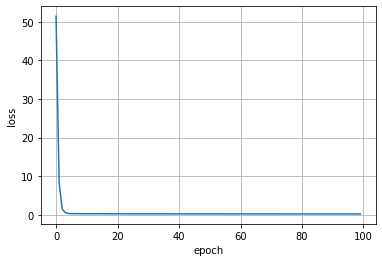

In [240]:
plt.plot(history.history['loss'],label='train loss')
plt.grid(True)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()